# Monocular Depth/Alpha Sharpening Test

Depth Pro produces sharp depth. MoGe produces blurry depth with mask. Need a way to combine both to get both sharp depth and sharp mask.

This is a very basic, bare minimum prototype.

In [1]:
from depth_pro.utils import load_rgb
from depth_pro import depth_pro

import torch
import sys
import os

import matplotlib.pyplot as plt


In [2]:
config = depth_pro.DEFAULT_MONODEPTH_CONFIG_DICT
config.checkpoint_uri = os.path.join(os.path.dirname(depth_pro.__file__), "../../", config.checkpoint_uri)
print(config.checkpoint_uri)

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms(config, 'cuda', torch.float16)
model.eval()


/home/harry7557558/nerfstudio/ml-depth-pro/src/depth_pro/../.././checkpoints/depth_pro.pt


DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [3]:
def load_moge():
    try:
        from moge.model.v1 import MoGeModel
    except ImportError:
        raise ImportError("Import error, please install https://github.com/microsoft/moge")

    model = MoGeModel.from_pretrained("Ruicheng/moge-vitl").cuda().eval()
    return model

moge = load_moge()

/home/harry7557558/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/harry7557558/.local/lib/python3.10/site-packages/moge-1.0.0-py3.10.egg/moge/model/v1.py:171: UserWarning: The following deprecated/invalid arguments are ignored: {'output_mask': True, 'split_head': True}
  warnings.warn(f"The following deprecated/invalid arguments are ignored: {deprecated_kwargs}")


None


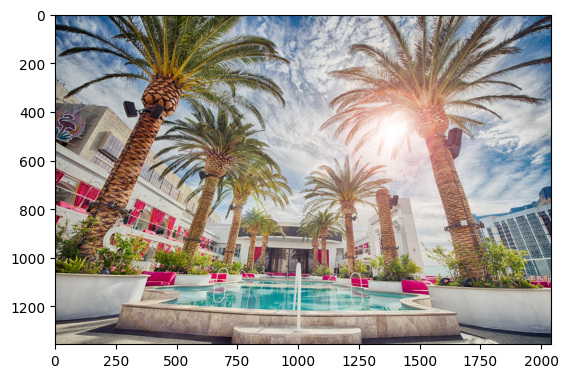

torch.Size([3, 1356, 2040]) torch.float16 tensor(0.1515, device='cuda:0', dtype=torch.float16) tensor(0.4575, device='cuda:0', dtype=torch.float16)


In [4]:
image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0003.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0053.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0177.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0244.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0276.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0680.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0748.png')
# image, _, f_px = load_rgb('/home/harry7557558/adr/coco/df2k/DIV2K/0799.png')
print(f_px)

plt.figure()
plt.imshow(image)
plt.show()

image = transform(image)
print(image.shape, image.dtype, image.mean(), image.std())


In [5]:
prediction = model.infer(image, f_px=f_px)
depth_sharp = prediction["depth"]  # Depth in [m].
torch.cuda.empty_cache()

print(depth_sharp.shape)

torch.Size([1356, 2040])


torch.Size([1356, 2040])
torch.Size([1356, 2040])


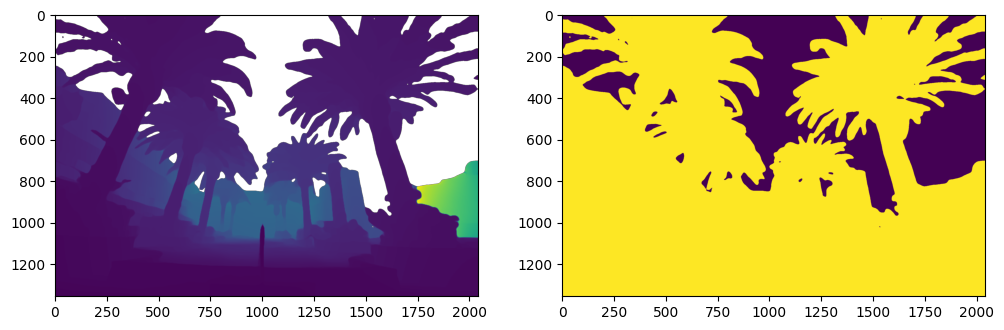

In [6]:
output = moge.infer(image)
depth_blurry = output['depth']
mask_blurry = output['mask']
print(depth_blurry.shape)
print(mask_blurry.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
ax1.imshow(depth_blurry.cpu().numpy())
ax2.imshow(mask_blurry.cpu().numpy())
plt.show()

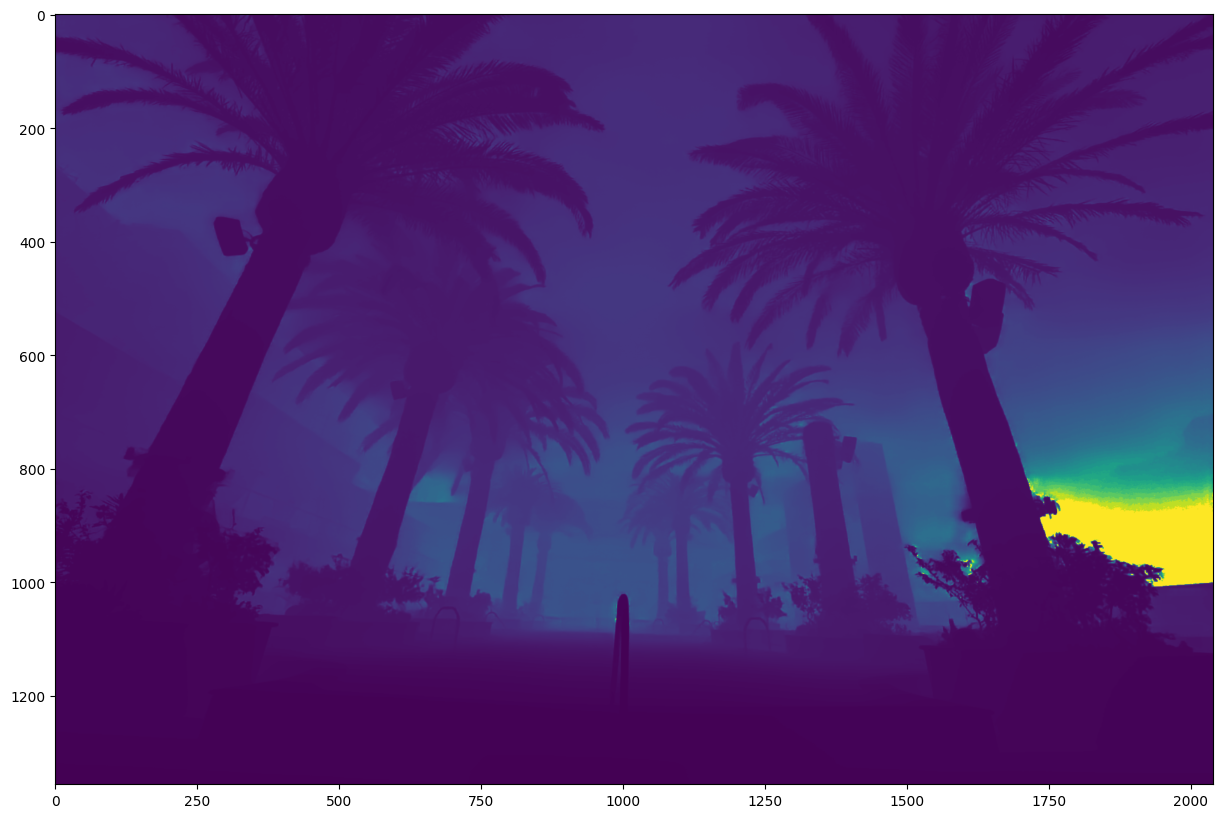

In [7]:
plt.figure(figsize=(15, 10))
z1 = torch.quantile(depth_sharp, 0.99)
plt.imshow(torch.clip(depth_sharp, max=z1).cpu().numpy())
plt.show()

In [8]:
from torchvision.transforms.functional import gaussian_blur

In [9]:
def downscale_image(im):
    im = im.float()
    h0, w0 = im.shape[:2]
    size = 384
    sc = min(size / min(h0, w0), 1)
    h1, w1 = int(sc*h0+1), int(sc*w0+1)
    lq = torch.nn.functional.interpolate(
        im.reshape(1, 1, *im.shape[:2]),
        size=(h1, w1), mode='bilinear', align_corners=False
    )
    return lq.reshape((h1, w1))

def blur_image(im, sigma, plot=True):
    im = im.float()
    h0, w0 = im.shape[:2]
    size = 256
    sc = min(size / min(h0, w0), 1)
    h1, w1 = int(sc*h0+1), int(sc*w0+1)
    lq = torch.nn.functional.interpolate(
        im.reshape(1, 1, *im.shape[:2]),
        size=(h1, w1), mode='bilinear', align_corners=False
    )
    # print(lq.shape)
    blur = gaussian_blur(lq, kernel_size=(3*sigma+1,3*sigma+1), sigma=sigma)
    # blur = blur.reshape(size, size, 1)
    # print(blur.shape)

    if plot:
        plt.figure()
        plt.imshow(blur.squeeze().cpu().numpy())
        plt.show()

    hq = torch.nn.functional.interpolate(
        lq,
        size=(h0, w0), mode='bilinear', align_corners=False
    )
    # print(hq.shape)
    return hq.reshape((h0, w0))

z1 = torch.quantile(depth_sharp, 0.98)
depth_sharp_clipped = torch.clip(depth_sharp, max=z1)
# depth_sharp_blurred = blur_image(depth_sharp_clipped, 32)
# print(depth_sharp_blurred.shape)

In [10]:
# mask_blurred = blur_image(mask_blurry, 32)

torch.Size([36, 222530])
<function fit_distortion_model.<locals>.pred at 0x7ea1bffb6050>
torch.Size([1356, 2040])


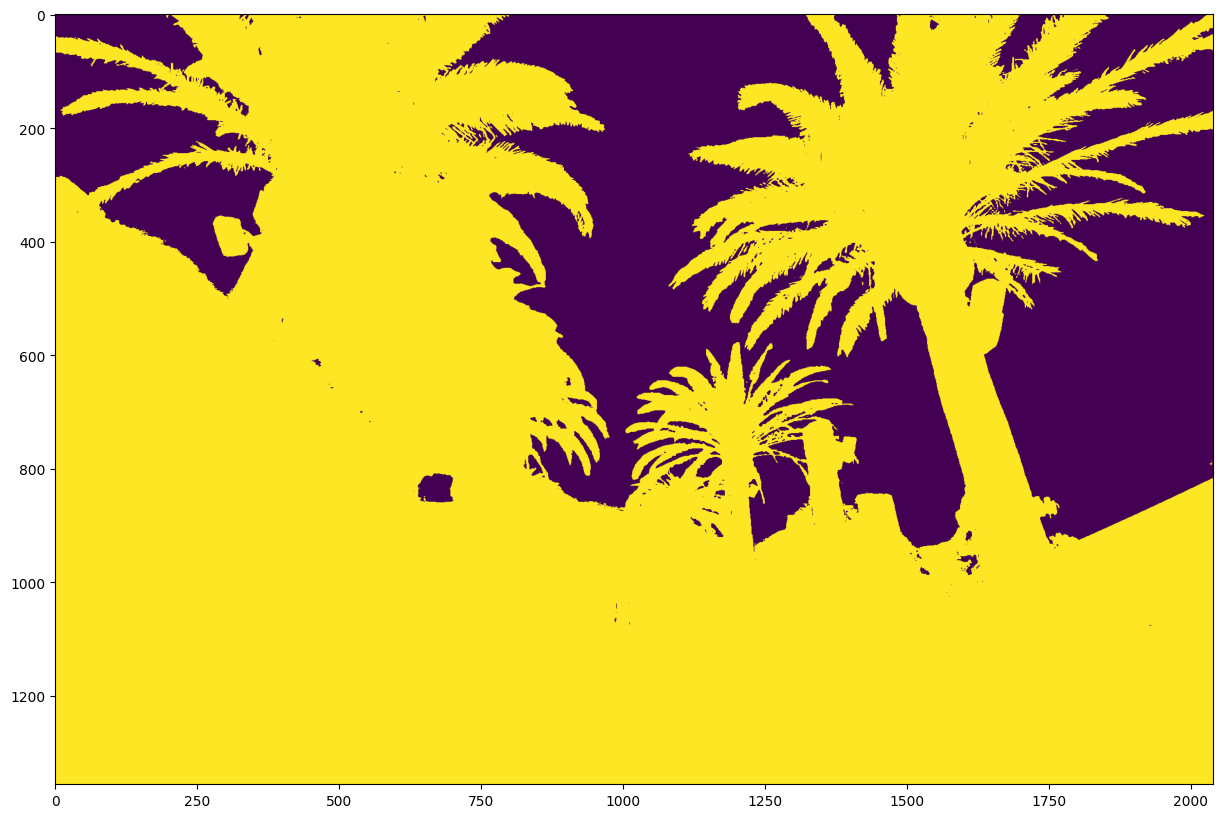

In [11]:
import math

def generate_depth_embedding(x, _uv_cache={}):
    h, w = x.shape[:2]
    x = x.flatten()

    uv_degree = 1
    z_degree = 3

    if (h, w) not in _uv_cache:
        u = (torch.arange(w, dtype=torch.float32)+0.5)/w * 2.0 - 1.0
        v = (torch.arange(h, dtype=torch.float32)+0.5)/h * 2.0 - 1.0
        u = u[None, :].float().cuda().repeat((h, 1))
        v = v[:, None].float().cuda().repeat((1, w))
        u, v = u.flatten(), v.flatten()

        uv = []
        for i in range(uv_degree+1):
            for j in range(uv_degree+1):
                uv.append(torch.cos(math.pi/2*i*u)*torch.cos(math.pi/2*j*v))
                if j != 0:
                    uv.append(torch.cos(math.pi/2*i*u)*torch.sin(math.pi/2*j*v))
                if i != 0:
                    uv.append(torch.sin(math.pi/2*i*u)*torch.cos(math.pi/2*j*v))
                if i != 0 and j != 0:
                    uv.append(torch.sin(math.pi/2*i*u)*torch.sin(math.pi/2*j*v))

        uv = torch.stack(uv)
        _uv_cache[(h, w)] = uv

    else:
        uv = _uv_cache[(h, w)]

    A = []
    for k in range(z_degree+1):
        ed = x**k / math.factorial(k) * torch.exp(-x)
        A.append(ed * uv)
        # A.append(ed[None])
    # A.append(uv)
    return torch.concatenate(A)

def fit_distortion_model(x, y):
    # details: https://github.com/harry7557558/Graphics/blob/master/mapping/relative_depth_matching/depth_fitting_01.ipynb

    x_mean, x_std = torch.mean(x).item(), torch.std(x).item()
    x = (x - x_mean) / x_std

    A = generate_depth_embedding(x)
    print(A.shape)

    # linear least squares
    mat = A @ A.T
    vec = A @ y.flatten()
    c = torch.linalg.solve(mat, vec)
    # corr_depth = torch.relu(c @ A)

    def pred(x):
        h, w = x.shape[:2]
        x = (x - x_mean) / x_std
        A = generate_depth_embedding(x)
        return (c @ A).reshape(h, w)

    return pred

# TODO: logistic regression
dist_model = fit_distortion_model(
    downscale_image(depth_sharp_clipped),
    downscale_image(mask_blurry)
)
print(dist_model)
mask = dist_model(depth_sharp_clipped) > 0.75
print(mask.shape)
torch.cuda.empty_cache()

plt.figure(figsize=(15, 10))
plt.imshow(mask.cpu().numpy())
plt.show()

# plt.figure(figsize=(15, 10))
# plt.imshow(mask_blurry.cpu().numpy())
# plt.show()

In [12]:
# th_low = blur_image(depth_sharp_clipped * mask_blurry, True)
# th_high = blur_image(depth_sharp_clipped * ~mask_blurry, True)
# th_low = blur_image(torch.lerp(depth_sharp_clipped, depth_sharp_blurred, mask_blurry.float()), 16)

In [13]:
# mask = depth_sharp < torch.fmax(th_low, th_high)

# plt.figure()
# plt.imshow(mask.cpu().numpy())
# plt.show()